# Example 5: Heading dependence

Inspect how grid maps change depending on the animal's heading. 
See `heading.py` for subroutines used in this notebook. 

## Setup workspace, load, and prepare dataset

In [1]:
from scipy.io import loadmat
import sys
sys.path.append('../')
from lgcpspatial.load_data     import Dataset
from lgcpspatial.lgcp2d        import DiagonalFourierLowrank
from lgcpspatial.lgcp2d        import coordinate_descent


# Load dataset R11_20190607_EC_02
L        = 128 # Grid size for position bins
pad      = 0.1 # Edge padding (Avoids circular convolution wrap-around)
dataset  = 'R11_20190607_EC_02.mat'
datadir  = '../example data/'
fn       = datadir + dataset
Fs       = loadmat(fn,squeeze_me=True)['pos_sample_rate']
data     = Dataset.from_file(fn,pad).prepare(L)

# Infer using parameters optimized by optimize_hyperparameters.ipynb
P        = 11.44 # Grid period
σ0       = 0.103 # Log-rate prior covariance kernel peak variance (zero lag variance)
model    = DiagonalFourierLowrank(σ0,P,data)
fit      = coordinate_descent(model,tol=1e-3)
μh,v,vfe = fit

## Fit maps for a range of heading angles

The inferred location of peaks changes depending on heading. This quickly searches all heading directions to find peaks that are well-localized in all directions. We look for peaks that can be identified uniquely over a good range of heading directions. 

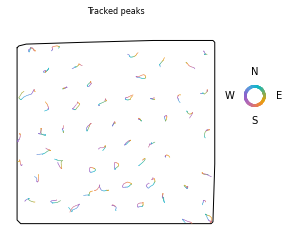

In [2]:
import numpy as np
from lgcpspatial.heading import get_peaks_at_heading_angles
from lgcpspatial.heading import link_peaks
from lgcpspatial.heading import plot_tracked_peaks

# Higher-resolution heading angle sweep
Nphi = 36
phis = np.linspace(0,2*np.pi,Nphi+1)[:-1]

# Grab peaks at a range of heading angles, then
# locate peaks tracked over a range of heading angles
peaks = get_peaks_at_heading_angles(data,model,phis)
edges = link_peaks(peaks,P/L/Nphi*10)
plot_tracked_peaks(peaks,edges,perim=data.arena.perimeter)

## Get confidence intervals for maps in cardinal directions

We also re-optimize prior variance for each single-direction dataset here; This doesn't change peak locations but ensures that our posterior covariances are OK (we will need them to estimate confidence intervals later). 

In [4]:
from lgcpspatial.heading     import smoothed_heading_angle
from lgcpspatial.grid_search import grid_search
from lgcpspatial.posterior   import SampledConfidence

px,py,spikes = data.px,data.py,data.spikes

# Prepare hyperparameter grid
rβ = 4  # Range (ratio) to search for optimal kernel height
Nβ = 21 # Kernel height search grid resolutions
βs = np.float32(np.exp(
    np.linspace(np.log(1/rβ),np.log(1*rβ),Nβ))[::-1])
pargrid = [βs]

# Define parameters for sampling
nsamples   = 4000 # Number of samples for peak distribution
resolution = 2    # Interpolation resolution 
radius     = P/2  # Peak region

# Define cardinal directions
phiW,phiS,phiE,phiN = 0, np.pi/2, np.pi, 3*np.pi/2
NSEW = np.array([phiN,phiS,phiE,phiW])

# Get Heading angle from lowpass kinematics derivative
# Heading angles range start as westward=0, then
# rotate anticlockwise to southward, eastward,...
heading_angle = smoothed_heading_angle(px,py)
prior_variance = σ0
samples, models, fits = [],[],[]
for iphi,phi in enumerate(NSEW): 
    # Heading-weighted data binning
    sw  = np.maximum(0,np.cos(heading_angle-phi))**2
    data2 = data.reweighted(sw)
    
    def evaluate_ELBO(parameters,state):
        β       = parameters[0]
        μ,v,μh  = (None,)*3 if state is None else state
        model   = DiagonalFourierLowrank(
            prior_variance/β,P,data2)
        μh,v,nl = coordinate_descent(model)
        return (model.F.T@μh ,v,μh), -nl, model
    # Run overall grid search
    bestix,bestpars,bestresult,allresults =\
        grid_search(pargrid,evaluate_ELBO)
    beta = bestpars[0]
    newsigma = σ0/beta
    print('σ0   = %f'%σ0)
    print('β    = %f'%beta)
    print('σ0/β = %f'%newsigma)
    # Infer and save
    model= DiagonalFourierLowrank(newsigma,P,data2)
    fit  = coordinate_descent(model,tol=1e-3)
    
    # sample (density, pfield, mask, rx, ry, totals)
    sample = SampledConfidence(
        data,model,fit,radius,resolution,nsamples,doplot=False,pct=95)
    samples.append(sample)
    models .append(model)
    fits   .append(fit)

[7](1.52e+00) loss=-1.203901e+033(done)
σ0   = 0.103000
β    = 1.319508
σ0/β = 0.078059
[13](6.60e-01) loss=-1.206408e+03(done)
σ0   = 0.103000
β    = 0.757858
σ0/β = 0.135909
[12](7.58e-01) loss=-1.191370e+03(done)
σ0   = 0.103000
β    = 0.870551
σ0/β = 0.118316
[9](1.15e+00) loss=-1.175050e+033(done)
σ0   = 0.103000
β    = 1.000000
σ0/β = 0.103000


## Show peak densities

Text(0.5, 1.0, 'Northward (blue) vs\nSouthward (orange)')

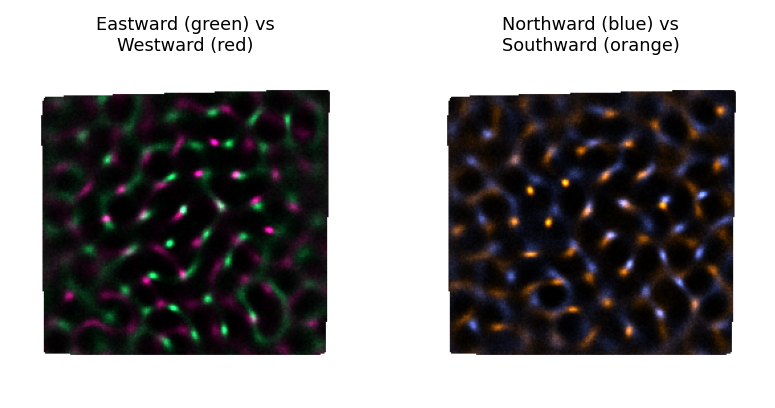

In [5]:
from lgcpspatial.load_data import Arena
from lgcpspatial.plot      import *

# Colors for each direction
cW = [0.9,.05,0.6] # Magenta
cS = [1.0,0.5,0.0] # Orange
cE = [0.1,.95,0.4] # Bright green
cN = [0.4,0.5,1.0] # Azure

pct  = 99.9 # Saturate pixels above this
mask = Arena(data.px,data.py,L,resolution).mask
N,S,E,W = [s.samples.density for s in samples]

figure(figsize=(6,3),dpi=160)
subplot(121)
colors  = array([cE,cW])
RGBEW   = clip(einsum('dc,dxy->xyc',colors,
    array([(E/np.percentile(E,pct)),(W/np.percentile(W,pct))])),0,1)
RGBEW[~mask,...] = 1
imshow(RGBEW,origin='lower')
noxyaxes()
title('Eastward (green) vs\nWestward (red)',pad=0)
subplot(122)
colors  = array([cN,cS])
RGBNS   = clip(einsum('dc,dxy->xyc',colors,
    array([(N/np.percentile(N,pct)),(S/np.percentile(S,pct))])),0,1)
RGBNS[~mask,...] = 1
imshow(RGBNS,origin='lower')
noxyaxes()
title('Northward (blue) vs\nSouthward (orange)',pad=0)

## Confidence ellipses and p-values for peak shifts

Note that the statistics of individual grid fields within the same map are not independent, so correcting for multiple-comparisons here is tricky. We'll explore this later. 

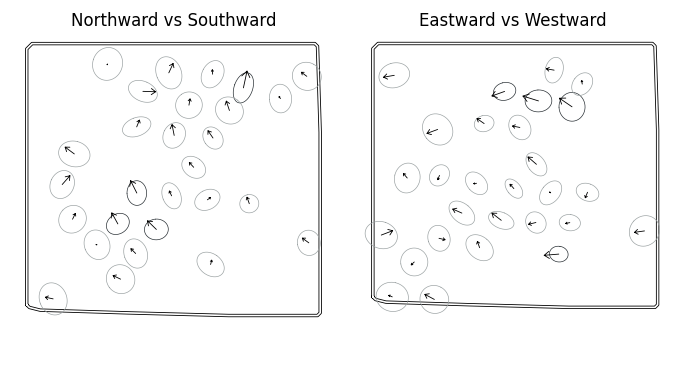

In [6]:
from lgcpspatial.heading import locate_opposites
from lgcpspatial.heading import plot_connection_arrow
from lgcpspatial.util import pdist
from numpy.linalg import norm

titles      = ['Northward vs Southward','Eastward vs Westward',]
iN,iS,iE,iW = argmin(cos(NSEW[None,:]-phis[:,None]),axis=0)
directions  = [iN,iE]

# Indexes of NS,EW cardinal pairs
cardinal = [(0,1),(2,3)] 

# P-value threshold to plot
pths = array([.05,1.0]) 

# Colors p-value threshold ellipsesdirections
cc = [array(BLACK)/2,(array(BLACK)+array(WHITE))/2] 

# Encode tracked peaks as complex to simplify math
q  = [[1,1j]@pk for pk in peaks]

# Tolerance for matching peaks
connection_radius = P/L/5

figure(figsize=(6,3),dpi=120)
subplots_adjust(left=0.06,bottom=0.0,right=1,top=.9,wspace=0)
allpairinfo = []
for iplot,i in enumerate(directions):
    subplot(1,2,iplot+1)
    '''
    Find connected peaks from opposing directions
    - q encodes (rx,ry) peak-<λ> as rx+1j*ry in [0,1]² normalized coordinates
    - There's a separate set of peaks for each direction
    - Means m1,m2 are sampled peak centroids ~ q
    - p95s: [[((ellipse_path),(μ,Σ)),… for each peak],… for each [N,S,E,W]]
    '''
    # match peaks
    iop,op = locate_opposites(peaks,P/L*0.67,i,edges)[:2] 
    # Get locations of these peaks encoded as complex number
    q1,q2  = q[i],q[iop]
    # Look up 90% Σs
    direction2,direction1 = cardinal[iplot]
    g1  = samples[direction1].gaussians
    g2  = samples[direction2].gaussians
    # unpack μs, Σs of gaussian confidence intervals
    m1,S1  = map(float32,zip(*g1)) 
    m2,S2  = map(float32,zip(*g2)) 
    # encode peak means as complex
    z1,z2  = m1@[1,1j],m2@[1,1j] 

    # Register connected-peak data & posterior-confidence info
    # These should be close, but aren't exactly equal
    # Match them up based on proximity.
    d1,d2 = pdist(z1,q1),pdist(z2,q2)
    i1,i2 = argmin(d1,0),argmin(d2,0)
    i1[np.min(d1,0)>=connection_radius] = -1
    i2[np.min(d2,0)>=connection_radius] = -1
    op2 = int32(zeros(len(z1)))-1
    for j,k in enumerate(op):
        if k<0: continue
        l,m = i1[j],i2[k]
        if l>=0 and m>=0: op2[l]=m
    plot_connection_arrow(op2,z1,z2,color='k',lw=.5,zorder=99)

    # Get p-values using a z-test
    elps = [[] for p in pths]
    allp = []
    pairinfo = []
    for j,k in enumerate(op2):
        if k<0: continue
        m1,S1 = g1[j]
        m2,S2 = g2[k]
        pairinfo.append(((m1,S1),(m2,S2)))
        # Covariance of difference is sum of covariances
        S = S1+S2
        # Mean of difference is difference of means
        d = m2-m1
        # Find unit-direction of shift
        u = d/norm(d)
        # Obtain variance along shift direction
        z = norm(d)/sqrt(u@S@u)
        # Get p-value from z-score
        p = 1-scipy.stats.norm.cdf(z)
        allp.append(p)
        # Assign this pair to a signficicance bracket
        for ip,pth in enumerate(pths):
            if p<=pth:
                cross = covariance_crosshairs(S,p=0.95,draw_ellipse=True,draw_cross=False,mode='1D').T + m2
                elps[ip].extend(cross)
                elps[ip].append([NaN,]*2)
                break
    allpairinfo.append(pairinfo)

    # Plot ellipses (different colors for different significance)
    for ip,pth in enumerate(pths):   
        plot(*array(elps[ip]).T,lw=0.4,color=cc[ip])
    
    # Add arena bounding box and show plot
    plot(*data.arena.perimeter.T,lw=2,color='k',zorder=-99)
    plot(*data.arena.perimeter.T,lw=1,color='w',zorder=-98)
    axis('square')
    axis('off')
    title(titles[iplot],pad=0,fontsize=10)
    ylim(*ylim()[::-1])

## Overall significance summary

Is there a significant *consistent shift* between all tracked fields? It looks that way, but the statistics for individual fields are correlated due to the Gaussian process prior. To address this, we can sample all fields jointly and compare the average shift over all tracked fields within a sample. The joint sampling preserves correlations. We draw samples for two opposing directs and compare all pairs of multi-field samples where at least 60% of the tracked fields are present (some fields don't appear in all samples). 

Mean shift is 6.24 cm, p=0.0003, angle 67.712938
Mean shift is 6.16 cm, p=0.0006, angle 15.744785


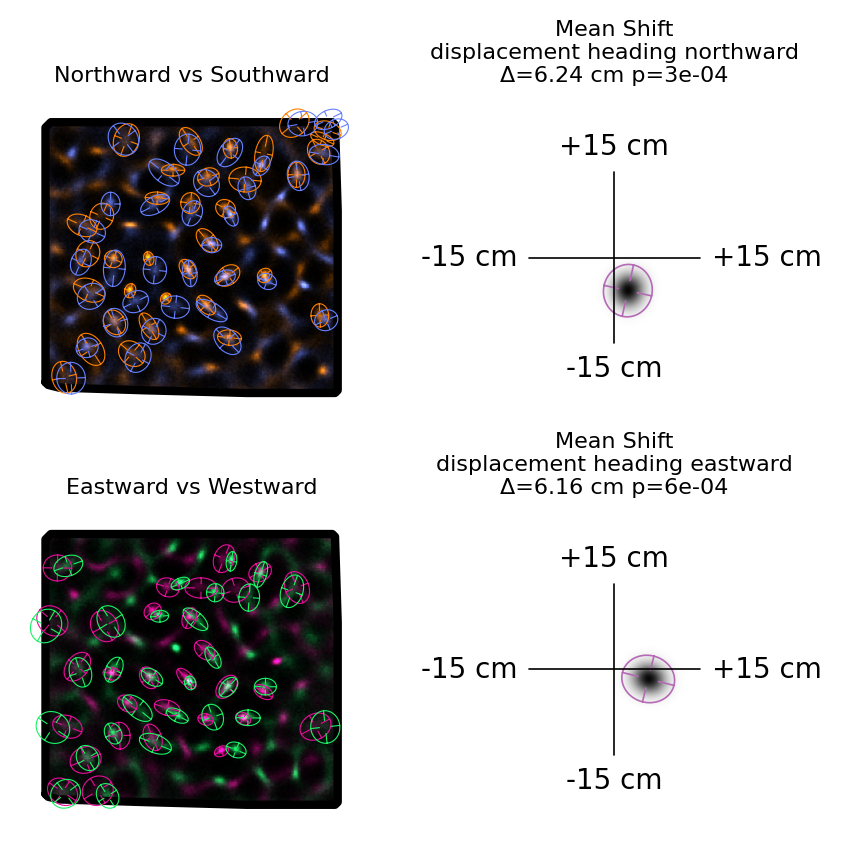

In [16]:
from lgcpspatial.posterior import sample_posterior_lograte
from lgcpspatial.posterior import interpolate_peaks
from lgcpspatial.heading   import pair_points

connection_radius = P/L*0.45
nsamples = 1500

# Precompute to convert results to physical units
scale = data.extent[1]-data.extent[0]
z0 = data.extent[0] + 1j*data.extent[2]
m_per_pixel = diff(data.extent[:2])[0]/L

figure(figsize=(5,5),dpi=200)

for iplot,iph in enumerate(directions):

    # Match peaks based on fast (non-optimized) posterior means
    # iop: which phase index is opposite of this one
    # op:  index to matches in opposite direction (-1 if not matches)
    iop,op = locate_opposites(peaks,P/L*0.67,iph,edges)[:2] 
    
    # Locations of matched peak in this direction and its opposite
    z1 = [1,1j]@peaks[iph][:,   op>=0 ]
    z2 = [1,1j]@peaks[iop][:,op[op>=0]]

    correlated_samples = []
    all_fields = []
    direction2,direction1 = cardinal[iplot]
    for zi,direction in zip([z1,z2],[direction1,direction2]):
        
        model = models[direction]     
        μh,v  = fits[direction][:2]

        # Draw samples from the posterior
        # (collect lists of peaks as complex numbers for each sample)
        sample   = sample_posterior_lograte(model,μh,v,nsamples)
        ix,iy,iz = interpolate_peaks(sample,
            r=int(P/2),
            height_threshold=percentile(sample,50))
        q = ix+1j*iy
        psamples = [q[iz==s] for s in range(nsamples)]

        # For each tracked peak, record correlated samples
        s1 = full((nsamples,len(zi)),NaN,'F')
        for ii,qi in enumerate(psamples):
            iz,iq = pair_points(zi,qi,connection_radius)
            s1[ii,iz] = qi[iq]
            
        correlated_samples.append(s1)
        all_fields.append(zi)
    
    # Switch to units of meters
    all_fields = array(all_fields)*scale+z0
    correlated_samples = complex64(correlated_samples)*scale+z0
    
    D = correlated_samples[1][None,:,:]-correlated_samples[0][:,None,:]
    n = correlated_samples.shape[-1]
    u = D.reshape(nsamples**2,n)[[nsamples,1]@int32(triu_indices(nsamples))]
    u = u[sum(isfinite(u),1)>n*0.6]
    Δ = nanmean(u,1)
    δ = mean(Δ)
    p = mean(real(Δ*exp(-1j*angle(δ)))<0)
    print('Mean shift is %0.2f cm, p=%0.4f, angle %f'%(abs(δ)*100,p,angle(δ)*180/pi))
    
    subplot(2,2,iplot*2+1)
    imshow([RGBNS,RGBEW][iplot],extent=array(data.extent)-m_per_pixel/2)
    plot(*c2p(p2c(data.arena.perimeter.T)*scale+z0),lw=3,color='k',clip_on=False)
    for j,(ss,fields) in enumerate(zip(correlated_samples,all_fields)):
        color = color=[[cS,cN],[cW,cE]][iplot][j]
        lines = []
        for qi in ss.T:
            lines+=[*covellipse_from_points(qi).T,NaN]
        plot(*c2p(lines),color=color,lw=0.4,zorder=10)

    axis('square')
    noxyaxes()
    ylim(ylim()[::-1])
    title(titles[iplot],pad=0)

    subplot(2,2,iplot*2+2)
    imshow(histogram2d(*c2p(Δ*100)[::-1],
           bins=linspace(-30,30,101),density=True)[0],
           extent=(-30,30)*2,cmap='gray_r',interpolation='bicubic')
    plot(*c2p(covellipse_from_points(Δ*100)),lw=0.6,color=MAUVE)
    axis('square')
    noxyaxes()
    xlim(-30,30)
    ylim(30,-30)
    axhline(0,.25,.75,color='k',lw=0.6)
    axvline(0,.25,.75,color='k',lw=0.6)
    text( 17,0,'+15 cm',ha='left',va='center')
    text(-17,0,'-15 cm',ha='right',va='center')
    text(0, 17,'-15 cm',ha='center',va='top')
    text(0,-17,'+15 cm',ha='center',va='bottom')
    title('Mean Shift\n'+'displacement heading %s\nΔ=%0.2f cm p=%0.0e'\
          %(titles[iplot].split()[0].lower(),abs(δ)*100,p),pad=0)
    